In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit, expit
import math

def c_and_cprime(t, pars):
    c = pars['c0'] * np.exp(-pars['gamma'] * t)
    cp = -pars['gamma'] * pars['c0'] * np.exp(-pars['gamma'] * t)
    return c, cp

def solve_p(p0, F, h, pars):
    p = p0.copy()
    eps_reg = 1e-5
    # First RK4 step (g1)
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g1 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Second RK4 step (g2)
    p = p0 + 0.5 * h * g1
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g2 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Third RK4 step (g3)
    p = p0 + 0.5 * h * g2
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g3 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Fourth RK4 step (g4)
    p = p0 + h * g3
    pdotF = np.dot(p, F)
    pdotp = np.dot(p, p) + eps_reg
    g4 = F - (pdotF / pdotp) * p - 0.5 * pars['gamma'] * p
    # Final RK4 update for p1
    p1 = p0 + (h / 6) * (g1 + 2 * g2 + 2 * g3 + g4)
    return p1

def kd_step(x, p, h, pars, Force):
    x = x + 0.5 * h * p
    F = Force(x)
    p = solve_p(p, F, h, pars)
    #c, _ = c_and_cprime(t + h, pars)
    #lam = np.sqrt(2 * c / np.dot(p,p))
    #p = lam * p
    x = x + 0.5 * h * p
    return x, p

def kd_traj(x0, p0, h, Ns, Pars, Model):
    T = [0]
    X = [x0]
    P = [p0]
    KE = [np.dot(p0, p0)]
    PE = [Model['U'](x0)]
    x = np.array(x0)
    p = np.array(p0)
    t = 0

    for _ in range(Ns):
        x, p = kd_step(x, p, h, Pars, Model['F'])
        t += h
        T.append(t)
        X.append(x)
        P.append(p)
        KE.append(np.dot(p, p))
        PE.append(Model['U'](x))

    return np.array(T), np.array(X), np.array(P), np.array(KE), np.array(PE)

def hd_step(x, p, h, pars, Force):
    gamma = pars['gamma']
    delta = 1/(1 + gamma * h)
    p = delta * p + h * delta * Force(x)
    x = x + h * p
    return x, p

def gd_step(x, p, h, pars, Force):
    x = x + h * Force(x)
    return x, p

def plot_diagnostics_2D(Q,P,T,U,potential_lambda,Pars,lim=3):
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    x = np.linspace(-lim, lim, 100)
    y = np.linspace(-lim, lim, 100)
    X, Y = np.meshgrid(x, y)
    Z = potential_lambda(X,Y)
    contourf = axs[0][0].contourf(X, Y, Z, levels=np.linspace(0, 9, 10), cmap='viridis', alpha=0.7)
    fig.colorbar(contourf, ax=axs[0][0], label='Potential U(q)')
    _, = axs[0][0].plot(Q[:, 0], Q[:, 1], lw=1.5, color = 'yellow')
    axs[0][0].set_xlabel('q1')
    axs[0][0].set_ylabel('q2')
    axs[0][0].set_title('Trajectory on Filled Contours of Potential Function')
    axs[0][0].grid(True)
    axs[0][1].plot(T, U)
    axs[0][1].set_xlabel('t')
    axs[0][1].set_ylabel('U(q)')
    axs[1][1].semilogy(T, np.exp(-Pars['gamma'] * T) , color = 'green', label = 'Desired KE')
    axs[1][1].semilogy(T, 0.5 * np.linalg.norm(P, axis=1)**2, label = 'KE')
    axs[1][1].set_xlabel('t')
    axs[1][1].set_ylabel('Energy')
    axs[1][0].semilogy(T, U) 
    axs[1][0].set_xlabel('Time')
    axs[1][0].set_ylabel('log U(q)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_compare(Q,P,T,U,potential_lambda,lim=3):
    Q_kd, Q_hd = Q
    P_kd, P_hd = P
    U_kd, U_hd = U

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    x = np.linspace(-lim, lim, 100)
    y = np.linspace(-lim, lim, 100)
    X, Y = np.meshgrid(x, y)
    Z = potential_lambda(X,Y)
    contourf = axs[0][0].contourf(X, Y, Z, levels=np.linspace(0, 9, 10), cmap='viridis', alpha=0.7)
    fig.colorbar(contourf, ax=axs[0][0], label='Potential U(q)')
    _, = axs[0][0].plot(Q_kd[:, 0], Q_kd[:, 1], lw=1.5, color = 'yellow', label = 'KD')
    _, = axs[0][0].plot(Q_hd[:, 0], Q_hd[:, 1], lw=1.5, color = 'orange', label = 'HD')
    axs[0][0].set_xlabel('q1')
    axs[0][0].set_ylabel('q2')
    axs[0][0].set_title('Trajectory on Filled Contours of Potential Function')
    axs[0][0].grid(True)
    axs[0][0].legend()
    axs[0][1].plot(T, U_kd, label = 'KD')
    axs[0][1].plot(T, U_hd, label = 'HD')
    axs[0][1].set_xlabel('t')
    axs[0][1].set_ylabel('U(q)')
    axs[0][1].legend()

    axs[1][1].plot(T, 0.5 * np.linalg.norm(P_kd, axis=1)**2, label = 'KD')
    axs[1][1].plot(T, 0.5 * np.linalg.norm(P_hd, axis=1)**2, label = 'HD')
    axs[1][1].set_xlabel('t')
    axs[1][1].set_ylabel('Energy')
    axs[1][1].legend()

    axs[1][0].semilogy(T, U_kd, label = 'KD')
    axs[1][0].semilogy(T, U_hd, label = 'HD')
    axs[1][0].set_xlabel('Time')
    axs[1][0].set_ylabel('log U(q)')
    axs[1][0].legend()
    plt.tight_layout()
    plt.show()

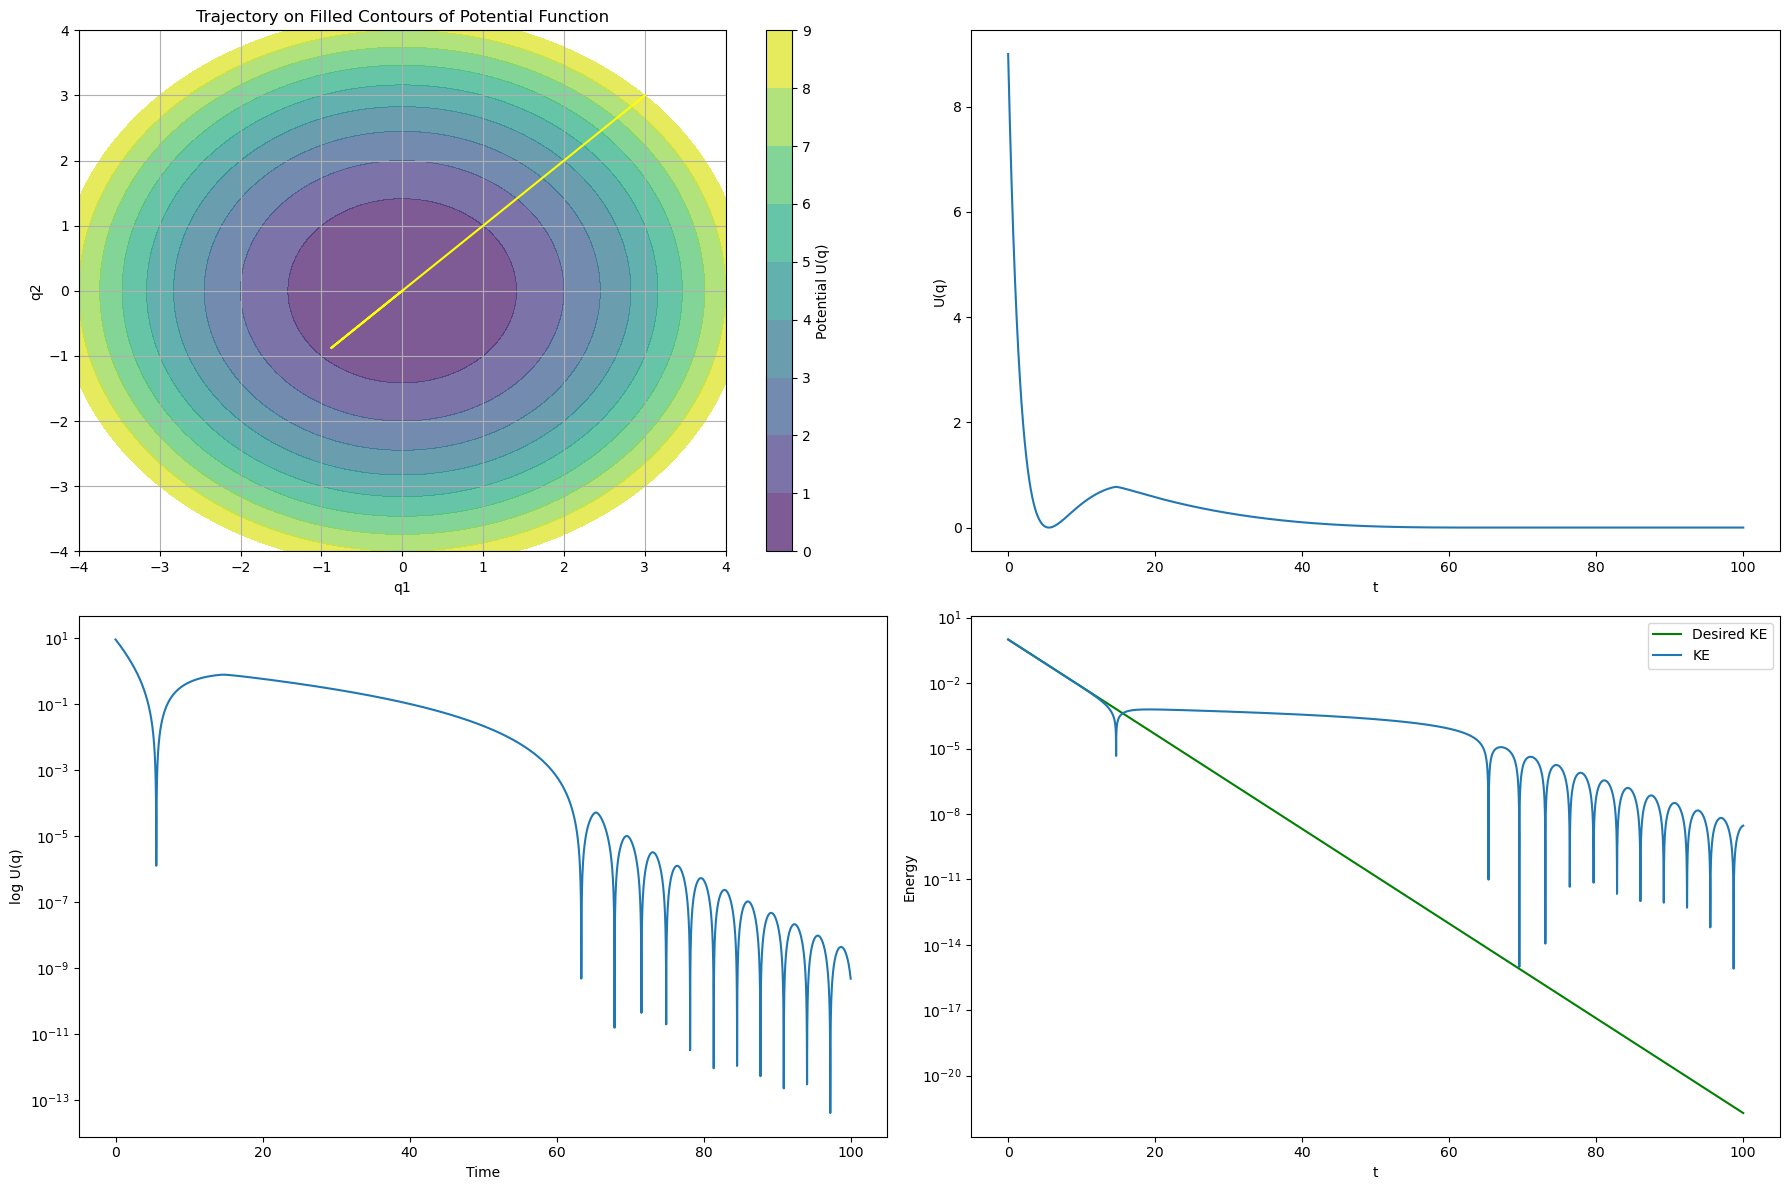

In [18]:
Pars = {}
Model = {}
Pars['gamma'] = 0.5
decay_exp = {
    'c': lambda t, P: np.maximum(np.exp(-P['gamma'] * t), 1e-8),
    'cp': lambda t, P: np.where(np.exp(-P['gamma'] * t) > 1e-8, -P['gamma'] * np.exp(-P['gamma'] * t), 0.0),
    'csqrt': lambda t, P: np.sqrt(np.maximum(np.exp(-P['gamma'] * t), 1e-8))
}
Pars['decay'] = decay_exp

U_quad = lambda x: 0.5 * (x[0]**2 + x[1]**2)
F_quad = lambda x: -np.array([x[0], x[1]])

Model['U'] = U_quad
Model['F'] = F_quad

x0 = np.array([3., 3.])
p0 = F_quad(x0) #0.5 * np.random.randn(2) # F_quad(x0, Pars)
p0 /= np.linalg.norm(p0)
p0 *= np.sqrt(2)
h = 0.01
Ns = 10000
T, X, P, KE, PE = kd_traj(x0, p0, h, Ns, Pars, Model)
plot_diagnostics_2D(X,P,T,PE,lambda X,Y: 0.5 * (1 * X**2 + 1 * Y**2),Pars,lim=4)

# 2D Correlated Quadratic Function

In [285]:
pars = {
    'c0': 1.,
    'gamma': 0.9
}
Ns = 1000
h = 0.1
q0 = np.array([1., 1.])
p0 = np.array([-1., 1.])
Q = [q0]
P = [p0]
T = [0]
K = [1]
q = q0
p = p0
t = 0
U_HO = lambda x: 0.5 * (10 * x[0]**2 + 1 * x[1]**2)
Force_HO = lambda x: np.array([-10 * x[0], -x[1]])
U = [U_HO(q)]
for n in range(Ns):
    q, p = kd_step(q, p, h, pars, Force_HO)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_HO(q))
    T.append(t)
Q_kd = np.array(Q)
P_kd = np.array(P)
U_kd = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: 0.5 * (10 * X**2 + 1 * Y**2)
#plot_diagnostics_2D(Q_kd,P_kd,T,U_kd,potential_lambda,pars['c0'],pars['gamma'],lim=3)

In [286]:
pars = {
    'gamma': 0.9,
    'c0': 0
}
Ns = 1000
h = 0.1
q0 = np.array([1., 1.])
p0 = np.array([-1., 1.])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0
U = [U_HO(q)]
for n in range(Ns):
    q, p = hd_step(q, p, h, pars, Force_HO)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_HO(q))
    T.append(t)
Q_hd = np.array(Q)
P_hd = np.array(P)
U_hd = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: 0.5 * (10 * X**2 + 1 * Y**2)

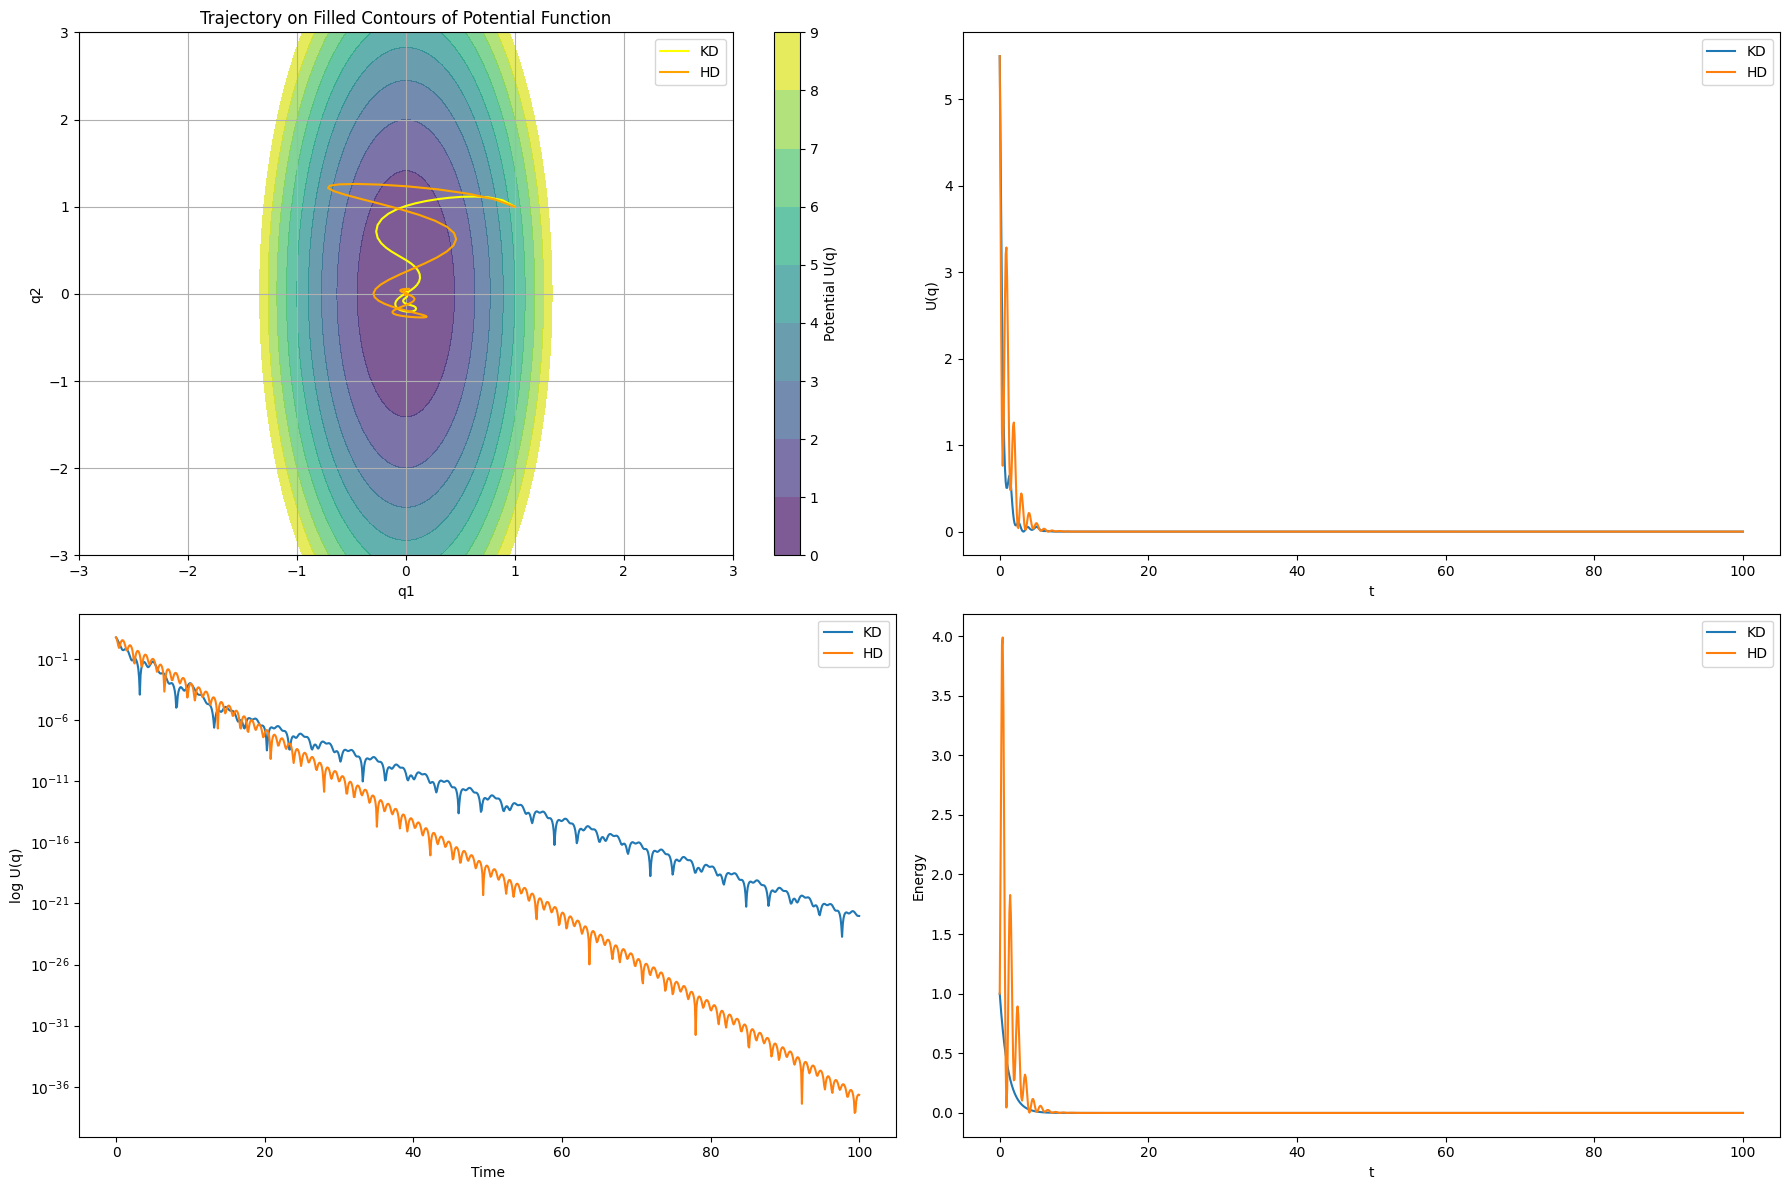

In [287]:
plot_compare((Q_kd,Q_hd),(P_kd, P_hd),T,(U_kd,U_hd),potential_lambda,lim=3)

# Superquadratic Function

In [148]:
U_SQ = lambda x: (x[0] + x[1])**4 + (x[0]/2 - x[1]/2)**4
Force_SQ = lambda x: np.array([
    -4 * (x[0] + x[1])**3 - 2 * (x[0]/2 - x[1]/2)**3,
    -4 * (x[0] + x[1])**3 + 2 * (x[0]/2 - x[1]/2)**3
])

pars = {
    'c0': 1.,
    'gamma': 0.99
}
Ns = 10000
h = 0.1
#q0 = np.array([1., 1.])
#p0 = np.array([-1., 1.])
q0 = np.array([0., -2.])
p0 = np.array([0., np.sqrt(2)])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0

U = [U_SQ(q)]
for n in range(Ns):
    q, p = kd_step(q, p, h, pars, Force_SQ)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_SQ(q))
    T.append(t)
Q_kd = np.array(Q)
P_kd = np.array(P)
U_kd = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: (X + Y)**4 + (X/2 - Y/2)**4
#plot_diagnostics_2D(Q,P,T,U,potential_lambda,pars['c0'],pars['gamma'],lim=3)
# Large stepsize creates a discretization error leading to a deviation in KE from desired KE.

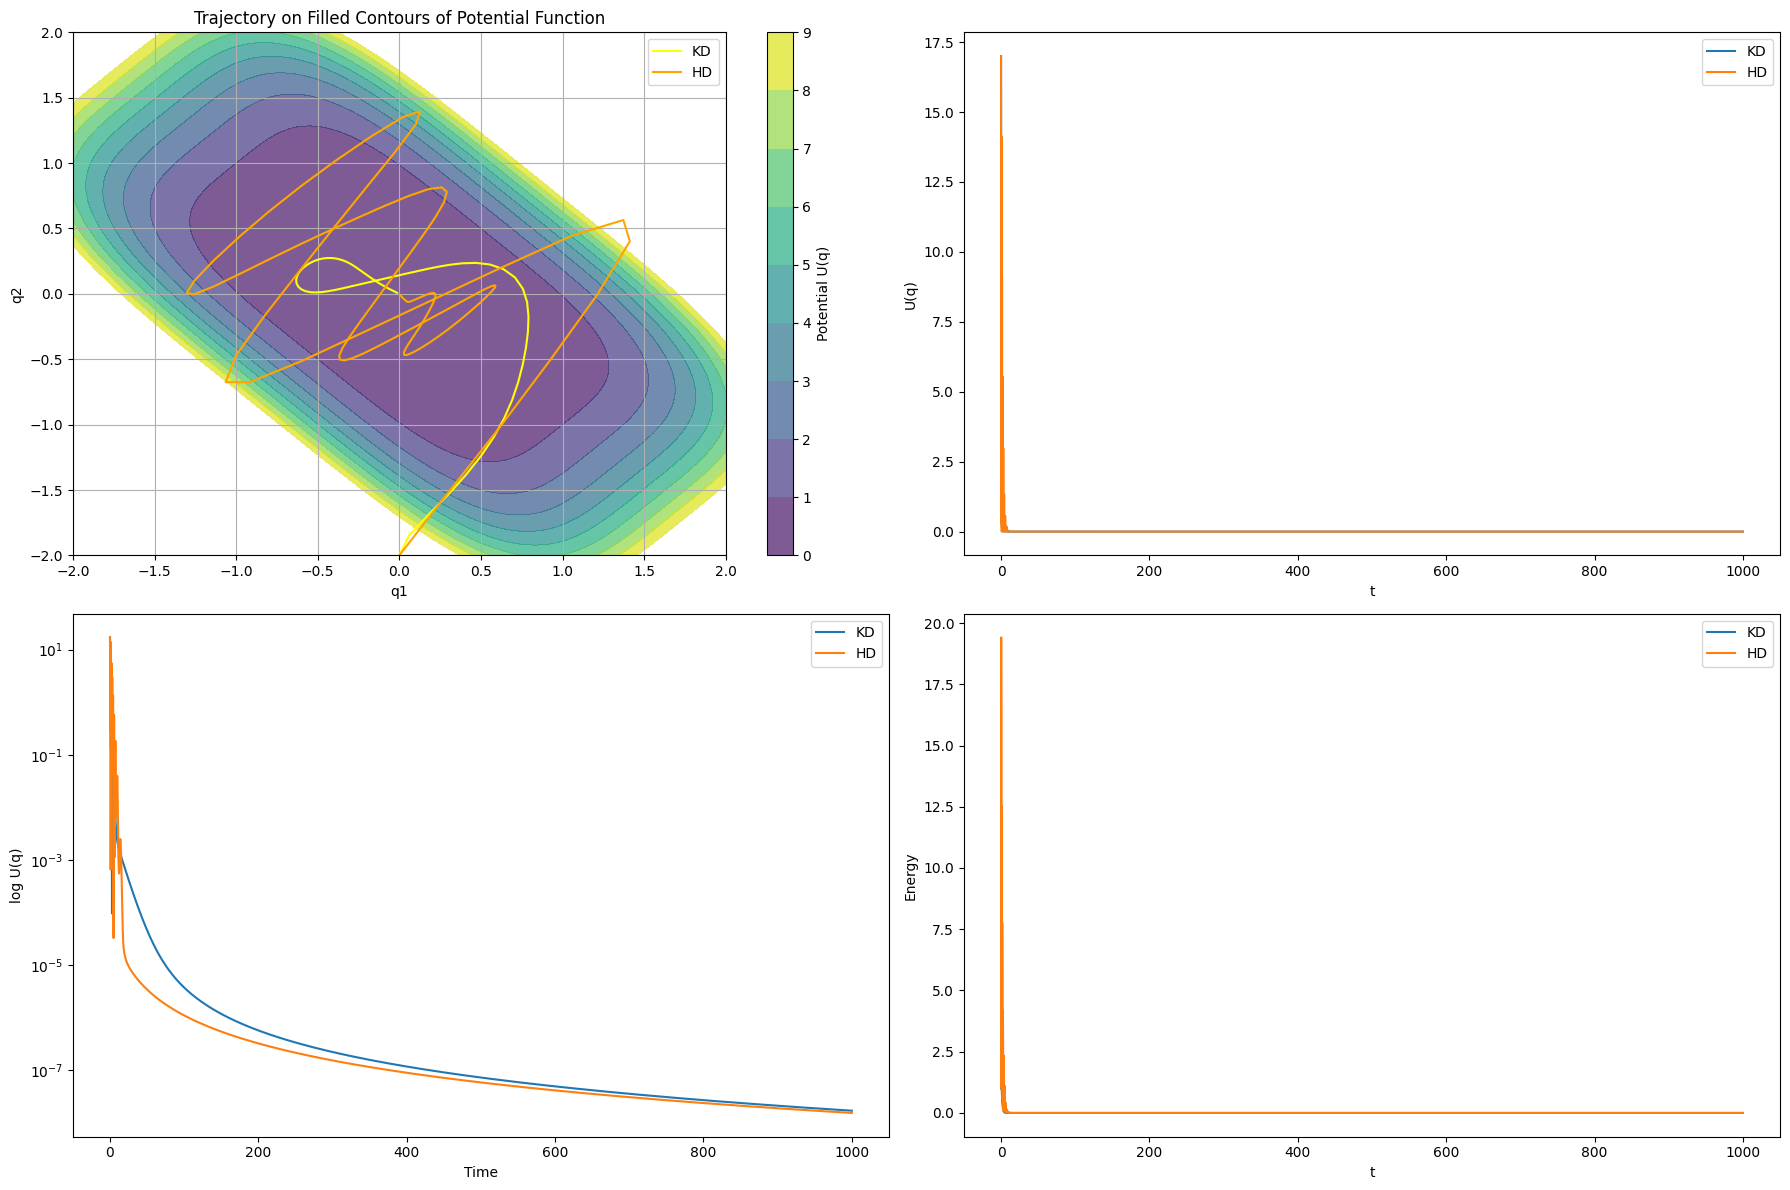

In [149]:
pars = {
    'c0': 0.,
    'gamma':  0.5
}
Ns = 10000
h = 0.1
#q0 = np.array([1., 1.])
#p0 = np.array([-1., 1.])
q0 = np.array([0., -2.])
p0 = np.array([0., np.sqrt(2)])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0

U = [U_SQ(q)]
for n in range(Ns):
    q, p = hd_step(q, p, h, pars, Force_SQ)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_SQ(q))
    T.append(t)
Q_hd = np.array(Q)
P_hd = np.array(P)
U_hd = np.array(U)
T = np.array(T)

plot_compare((Q_kd,Q_hd),(P_kd, P_hd),T,(U_kd,U_hd),potential_lambda,lim=2)

# LR Trap

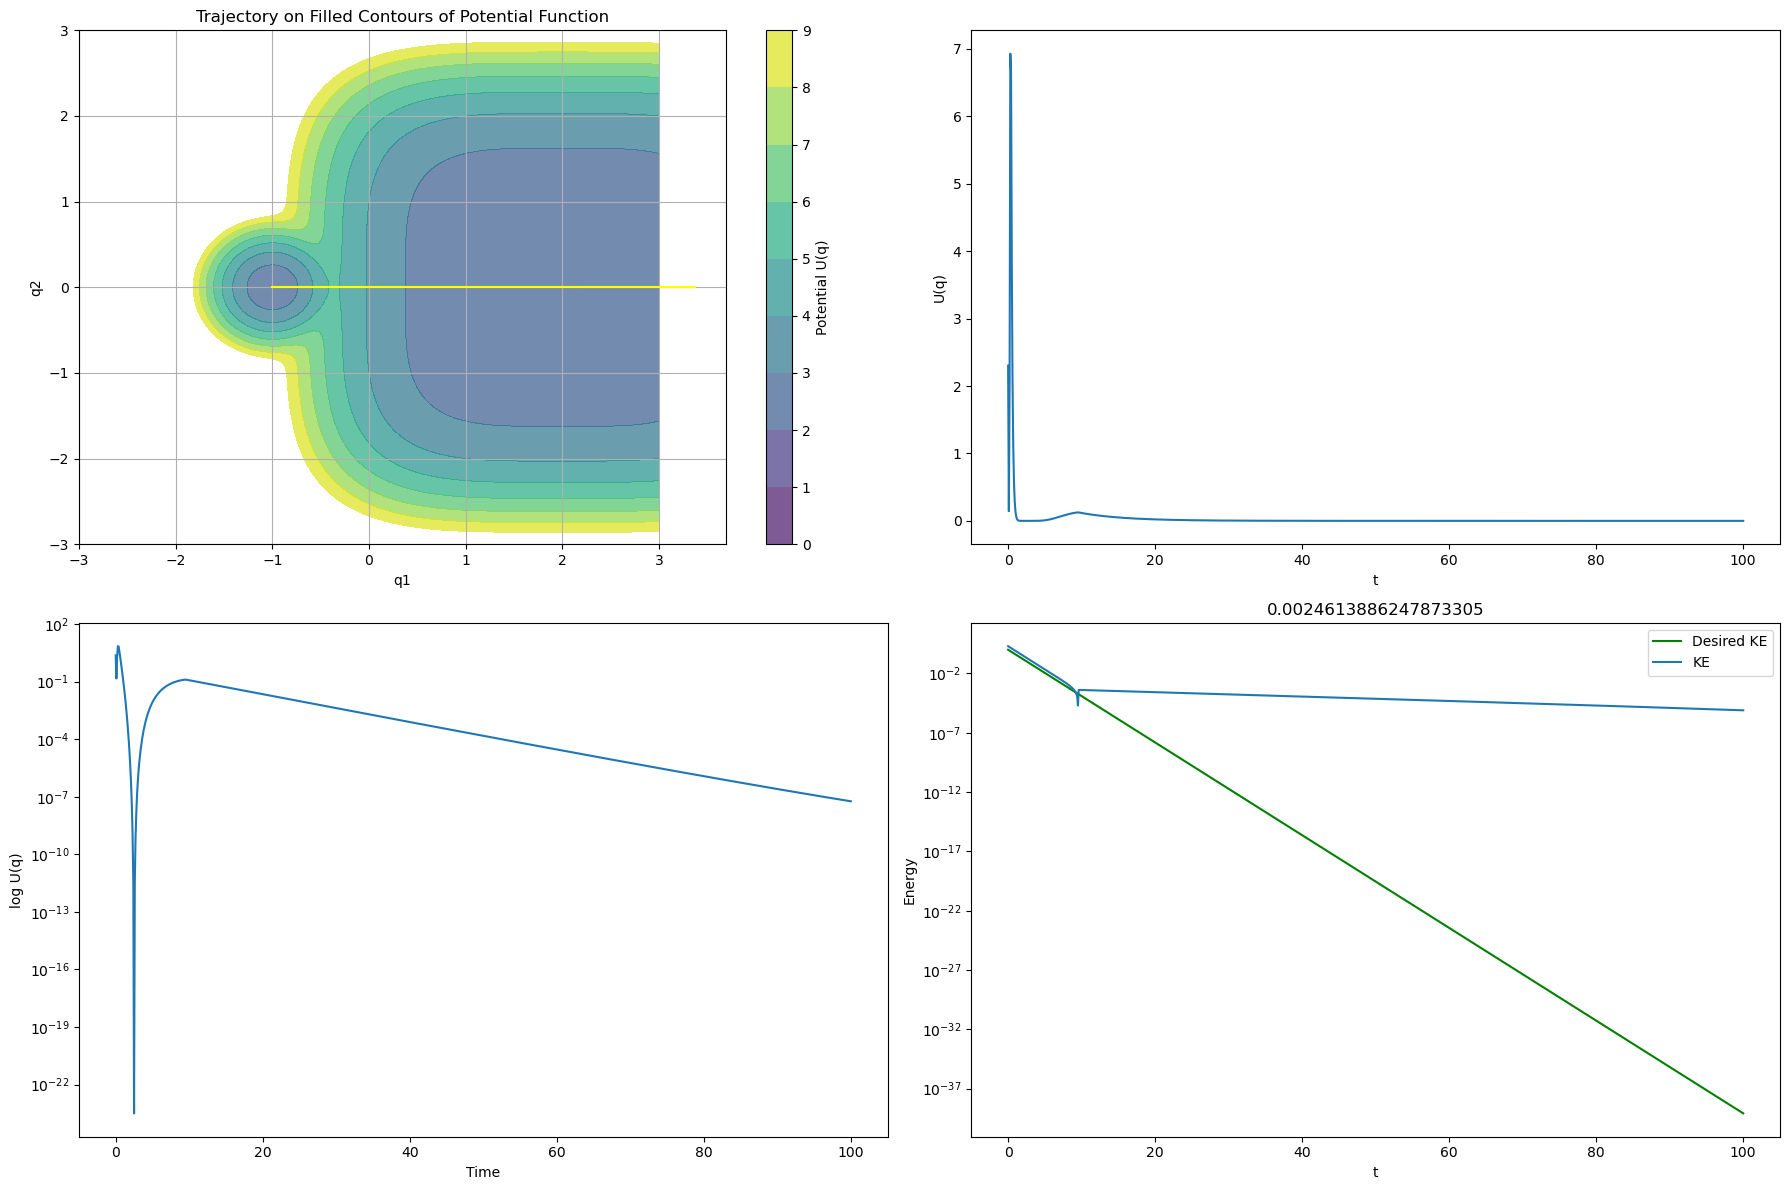

In [10]:
pars = {
    'c0': 1.,
    'gamma': 0.9
}
Ns = 1000
h = 0.1
q0 = np.array([-1., 0.])
p0 = np.array([2., 0.])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0

coeff = [0.1,0.1,-0.1, -10]
U_TRAP = lambda x: -np.log(0.1*np.exp(-0.1*((x[0]-2)**4+x[1]**4))+ 0.1 * np.exp(-10*((x[0]+1)**2+1*x[1]**2)))

def Force_TRAP(x):
    term1 = 0.1 * np.exp(-0.1 * ((x[0] - 2)**4 + x[1]**4))
    term2 = 0.1 * np.exp(-10 * ((x[0] + 1)**2 + x[1]**2))
    f_x = term1 + term2
    dterm1_dx0 = term1 * (-0.4 * (x[0] - 2)**3)
    dterm1_dx1 = term1 * (-0.4 * x[1]**3)
    dterm2_dx0 = term2 * (-20 * (x[0] + 1))
    dterm2_dx1 = term2 * (-20 * x[1])
    dU_dx0 = -(dterm1_dx0 + dterm2_dx0) / f_x
    dU_dx1 = -(dterm1_dx1 + dterm2_dx1) / f_x
    return -np.array([dU_dx0, dU_dx1])

U = [U_TRAP(q)]

for n in range(Ns):
    q, p = kd_step(q, p, h, pars, Force_TRAP)
    t += h
    Q.append(q)
    P.append(p)
    U.append((U_TRAP(q)-U_TRAP(np.array([2., 0.])))**2) # Note that U is now the squared loss rather than the potential
    T.append(t)

Q_kd = np.array(Q)
P_kd = np.array(P)
U_kd = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: -np.log(0.1*np.exp(-0.1*((X-2)**4+Y**4))+ 0.1 * np.exp(-10*((X+1)**2+1*Y**2)))
plot_diagnostics_2D(Q_kd,P_kd,T,U_kd,potential_lambda,pars['c0'],pars['gamma'],lim=3)
# Notes: Too small stepsize makes it stuck in local minima. Sensitive to momentum initialization.

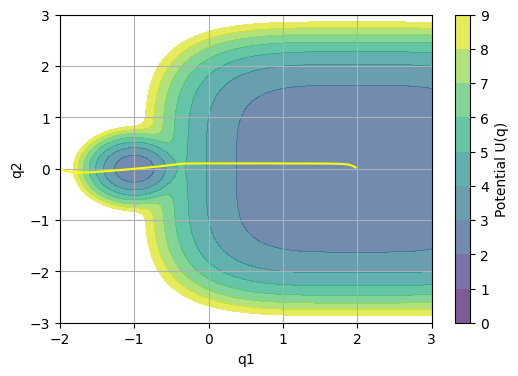

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
x = np.linspace(-2, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = potential_lambda(X,Y)
contourf = axs.contourf(X, Y, Z, levels=np.linspace(0, 9, 10), cmap='viridis', alpha=0.7)
fig.colorbar(contourf, ax=axs, label='Potential U(q)')
_, = axs.plot(Q_kd[:, 0], Q_kd[:, 1], lw=1.5, color = 'yellow')
axs.set_xlabel('q1')
axs.set_ylabel('q2')
axs.grid(True)

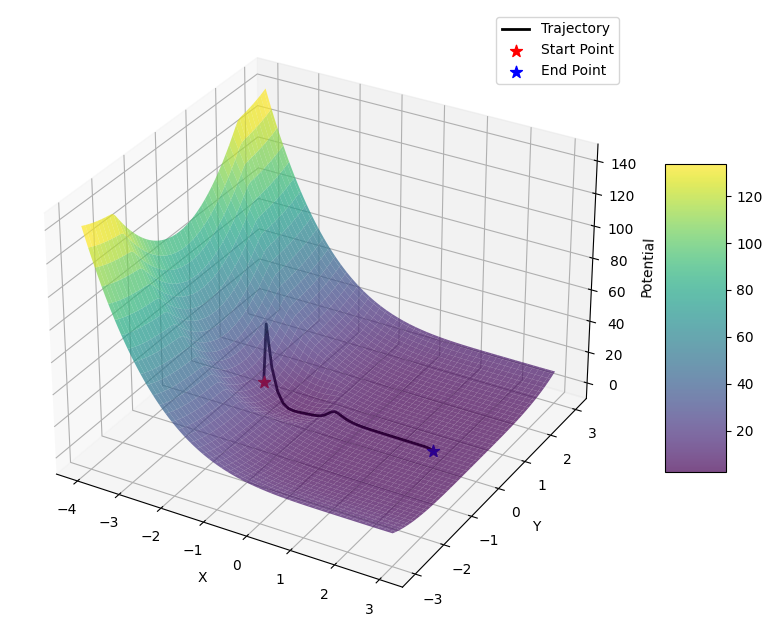

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

potential_lambda = lambda X, Y: -np.log(0.1 * np.exp(-0.1 * ((X - 2)**4 + Y**4)) + 0.1 * np.exp(-10 * ((X + 1)**2 + Y**2)))
x = np.linspace(-4, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = potential_lambda(X, Y)
X_traj, Y_traj = Q_kd[:, 0], Q_kd[:, 1]
Z_traj = U_kd
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.7)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.plot(X_traj, Y_traj, Z_traj, color='black', linewidth=2, label="Trajectory")
ax.scatter(X_traj[0], Y_traj[0], Z_traj[0], color='red', s=80, marker='*', label="Start Point")
ax.scatter(X_traj[-1], Y_traj[-1], Z_traj[-1], color='blue', s=80, marker='*', label="End Point")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
ax.legend()
plt.show()


# Rosenbrock Function

/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_2643/492858737.py:36: RuntimeWarning: invalid value encountered in divide
  p0 /= np.linalg.norm(p0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


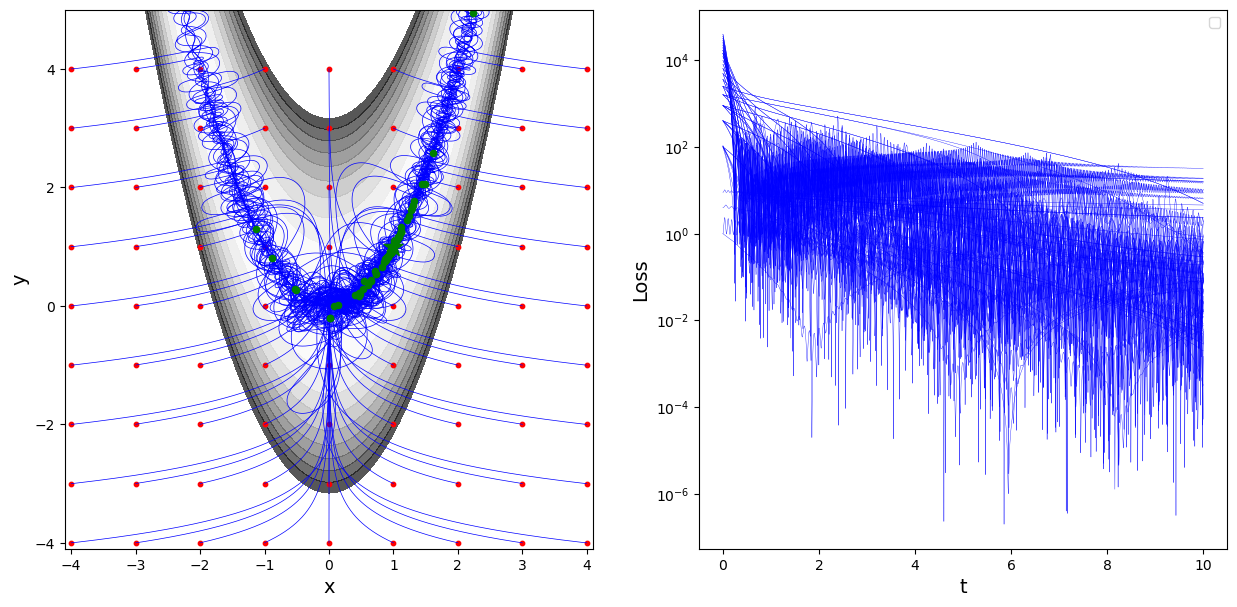

In [17]:
def U_rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def F_rosenbrock(x):
    return -np.array([
        -2 * (1 - x[0]) - 4 * 100 * (x[1] - x[0]**2) * x[0],
        2 * 100 * (x[1] - x[0]**2)
    ]).astype(float)

# Define the parameters and setup
Pars = {
    'gamma': .5,
    'coeff': [1, 100],
    'decay': {
    'c': lambda t, P: np.exp(-P['gamma'] * t),
    'cp': lambda t, P: -P['gamma']*np.exp(-P['gamma'] * t),
    'csqrt': lambda t, P: np.sqrt(np.exp(-P['gamma'] * t))
            }
}
Model = {'U': U_rosenbrock, 'F': F_rosenbrock}
Ns = 10000
h = 0.001

# Define the grid for contour plot
x_vals = np.linspace(-4, 5, 100)
y_vals = np.linspace(-4, 5, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.array([[U_rosenbrock([x, y]) for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])
# Plot the contour and trajectories
fig, axs = plt.subplots(1,2,figsize=(15, 7))
axs[0].contourf(X, Y, Z, levels=np.linspace(0, 1000, 10), cmap='Greys', alpha=0.7)
x_grid = np.array([[i, j] for i in range(-4, 5) for j in range(-4, 5)])
axs[0].scatter(x_grid[:, 0], x_grid[:, 1], color='red', s=10, label='Grid Points')
for x0 in x_grid:
    p0 = F_rosenbrock(x0) #np.random.randn(2)
    p0 /= np.linalg.norm(p0)
    T, X_traj, P, KE, PE = kd_traj(x0, p0, h, Ns, Pars, Model)
    X_traj = np.array(X_traj)
    axs[0].plot(X_traj[:, 0], X_traj[:, 1], linewidth=0.5, color = 'blue', zorder = 1)
    axs[0].scatter(X_traj[-1, 0], X_traj[-1, 1], color='green', s=20, zorder=2)  # Mark trajectory ends with green dots
    axs[1].plot(T, PE, linewidth=0.25, color = 'blue')
axs[1].semilogy(T, PE, linewidth=0.25, color = 'blue')
axs[0].scatter(1, 1, color='green', s=200, marker='*', label='Global Minimum', zorder = 2)
axs[0].set_xlabel('x', fontsize=14)
axs[0].set_ylabel('y', fontsize=14)
axs[1].set_xlabel('t', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[0].set_xlim(-4.1, 4.1)
axs[0].set_ylim(-4.1, 5)
plt.legend()
plt.show()


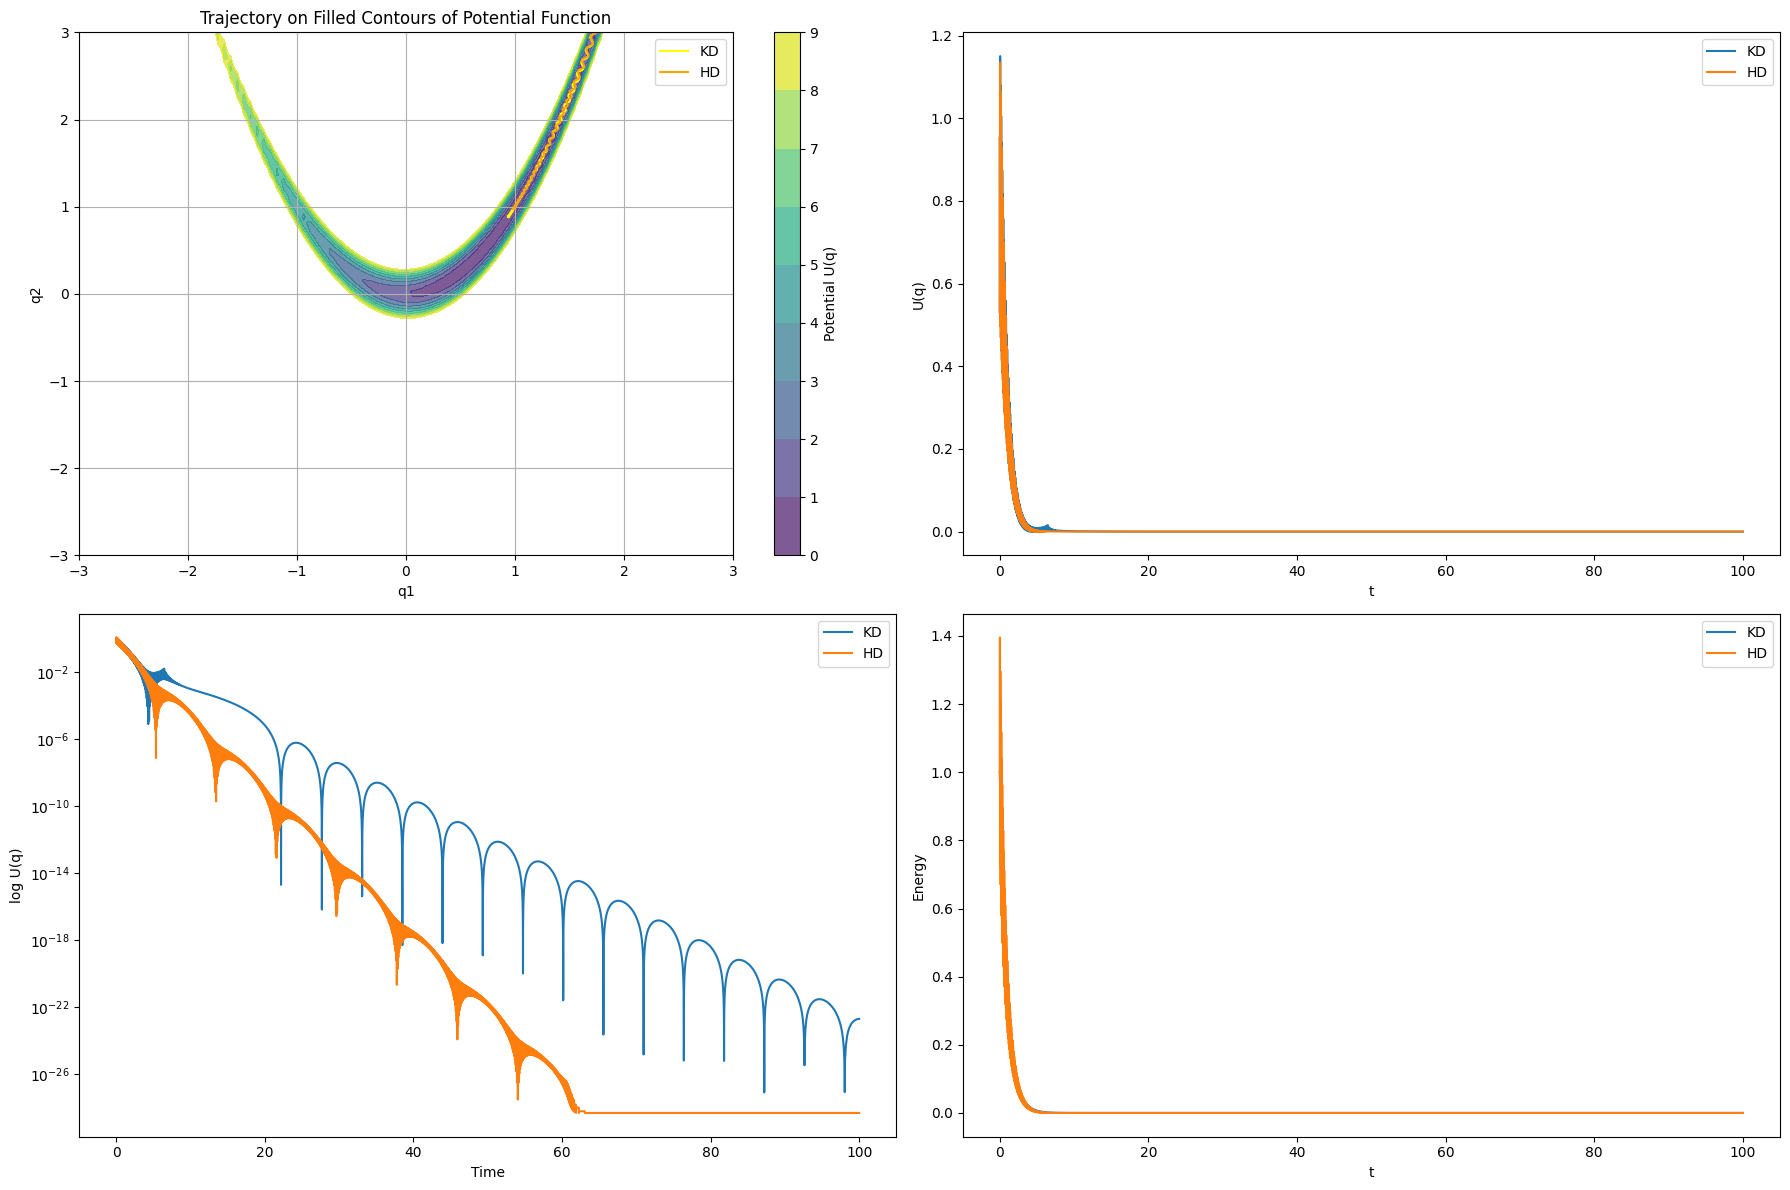

In [113]:
pars = {
    'c0': 0.,
    'gamma': 1.
}
Ns = 100000
h = 0.001
q0 = np.array([1.75, 3.])
p0 = np.array([-1., -1.])
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0
U = [U_rosenbrock(q)]


for n in range(Ns):
    q, p = hd_step(q, p, h, pars, FORCE_rosenbrock)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_rosenbrock(q))
    T.append(t)

Q_hd = np.array(Q)
P_hd = np.array(P)
U_hd = np.array(U)
T = np.array(T)
plot_compare((Q_kd,Q_hd),(P_kd, P_hd),T,(U_kd,U_hd),potential_lambda,lim=3)

# Note: Gamma took a lot of tuning to be better than KD.

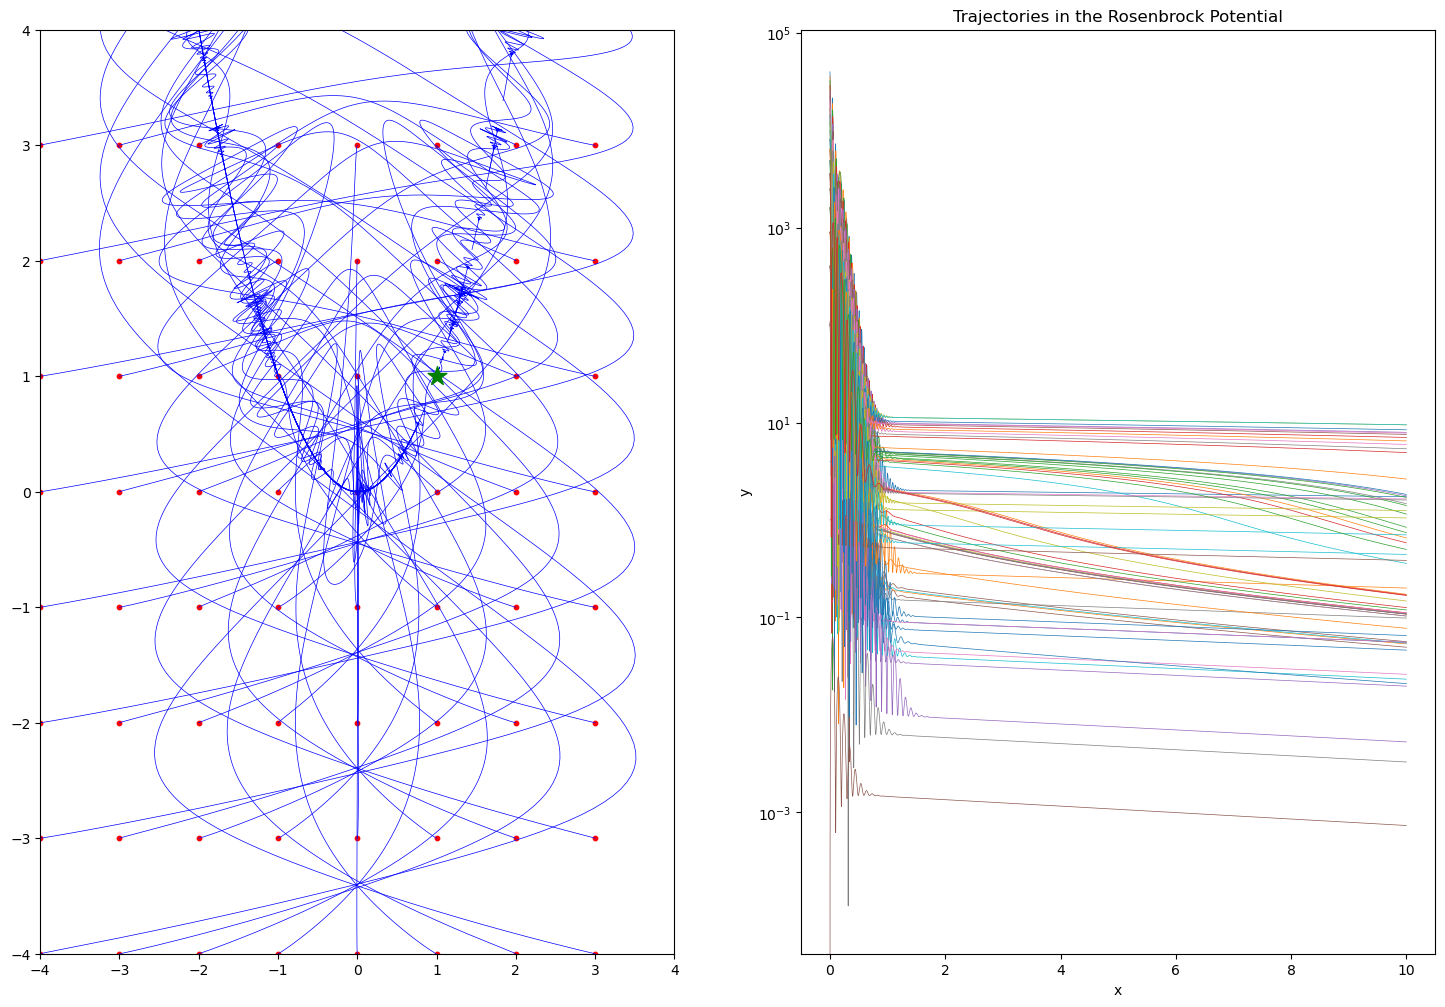

In [28]:
def U_rosenbrock(q):
    return 100 * (q[1] - q[0]**2)**2 + (1 - q[0])**2

def FORCE_rosenbrock(q):
    q0, q1 = q[0], q[1]
    dq0 = -400 * q0 * (q1 - q0**2) - 2 * (1 - q0)
    dq1 = 200 * (q1 - q0**2)
    return -np.array([dq0, dq1])

pars = {
    'c0': 0.,
    'gamma': 10.
}
h = 0.001
Ns = 10000
# Plot the contour and trajectories
fig, axs = plt.subplots(1,2,figsize=(18, 12))
#axs[0].contourf(X, Y, Z, levels=np.linspace(0, 1000, 10), cmap='viridis', alpha=0.7)
x_grid = np.array([[i, j] for i in range(-4, 4) for j in range(-4, 4)])
axs[0].scatter(x_grid[:, 0], x_grid[:, 1], color='red', s=10, label='Grid Points')
for q0 in x_grid:
    p0 = np.random.randn(2)
    p0 /= np.linalg.norm(p0)
    Q = [q0]
    P = [p0]
    T = [0]
    q = q0
    p = p0
    t = 0
    U = [U_rosenbrock(q)]
    for n in range(Ns):
        q, p = hd_step(q, p, h, pars, FORCE_rosenbrock)
        t += h
        Q.append(q)
        P.append(p)
        U.append(U_rosenbrock(q))
        T.append(t)
    Q = np.array(Q)
    P = np.array(P)
    U = np.array(U)
    T = np.array(T)
    axs[0].plot(Q[:, 0], Q[:, 1], label=f"Traj: x0={q0}, p0={p0}", linewidth=0.5, color = 'blue', zorder = 1)
    axs[1].semilogy(T, U, label=f"Traj: x0={q0}, p0={p0}", linewidth=0.5)
axs[0].scatter(1, 1, color='green', s=200, marker='*', label='Global Minimum', zorder = 2)
axs[0].set_xlim(-4, 4)
axs[0].set_ylim(-4, 4)
plt.title("Trajectories in the Rosenbrock Potential")
plt.xlabel("x")
plt.ylabel("y")
#plt.legend()
plt.show()

# High-Dimensional Quadratic Potential

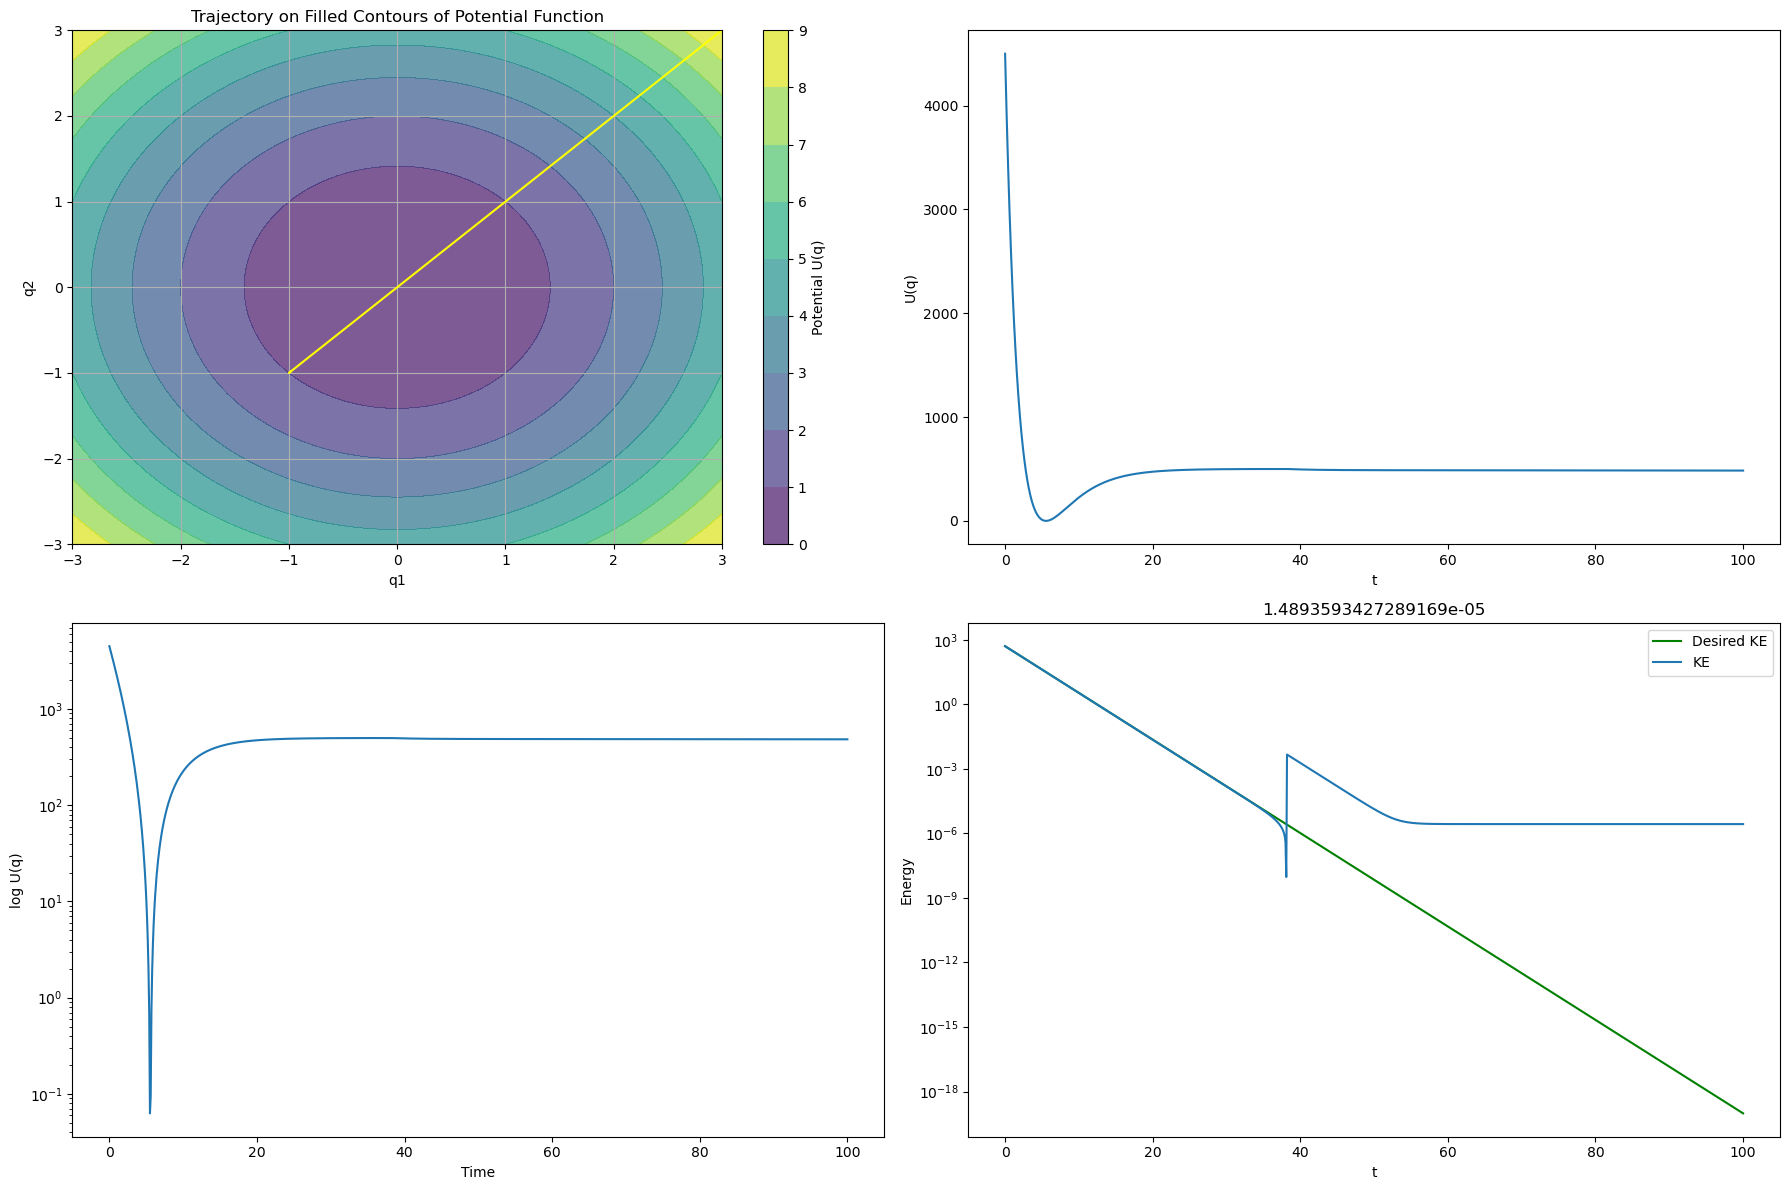

In [5]:
pars = {
    'c0': 500.,
    'gamma': 0.5
}
Ns = 1000
h = 0.1
q0 = np.ones(1000) * 3
p0 = -np.ones(1000)
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0
U_HO = lambda x: 0.5 * np.linalg.norm(x)**2
Force_HO = lambda x: -x
U = [U_HO(q)]
for n in range(Ns):
    q, p = kd_step(q, p, h, t, pars, Force_HO)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_HO(q))
    T.append(t)
Q = np.array(Q)
P = np.array(P)
U = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: 0.5 * (X**2 + Y**2)
plot_diagnostics_2D(Q,P,T,U,potential_lambda,pars['c0'],pars['gamma'],lim=3)

# High-Dimensional Correlated Quadratic Potential

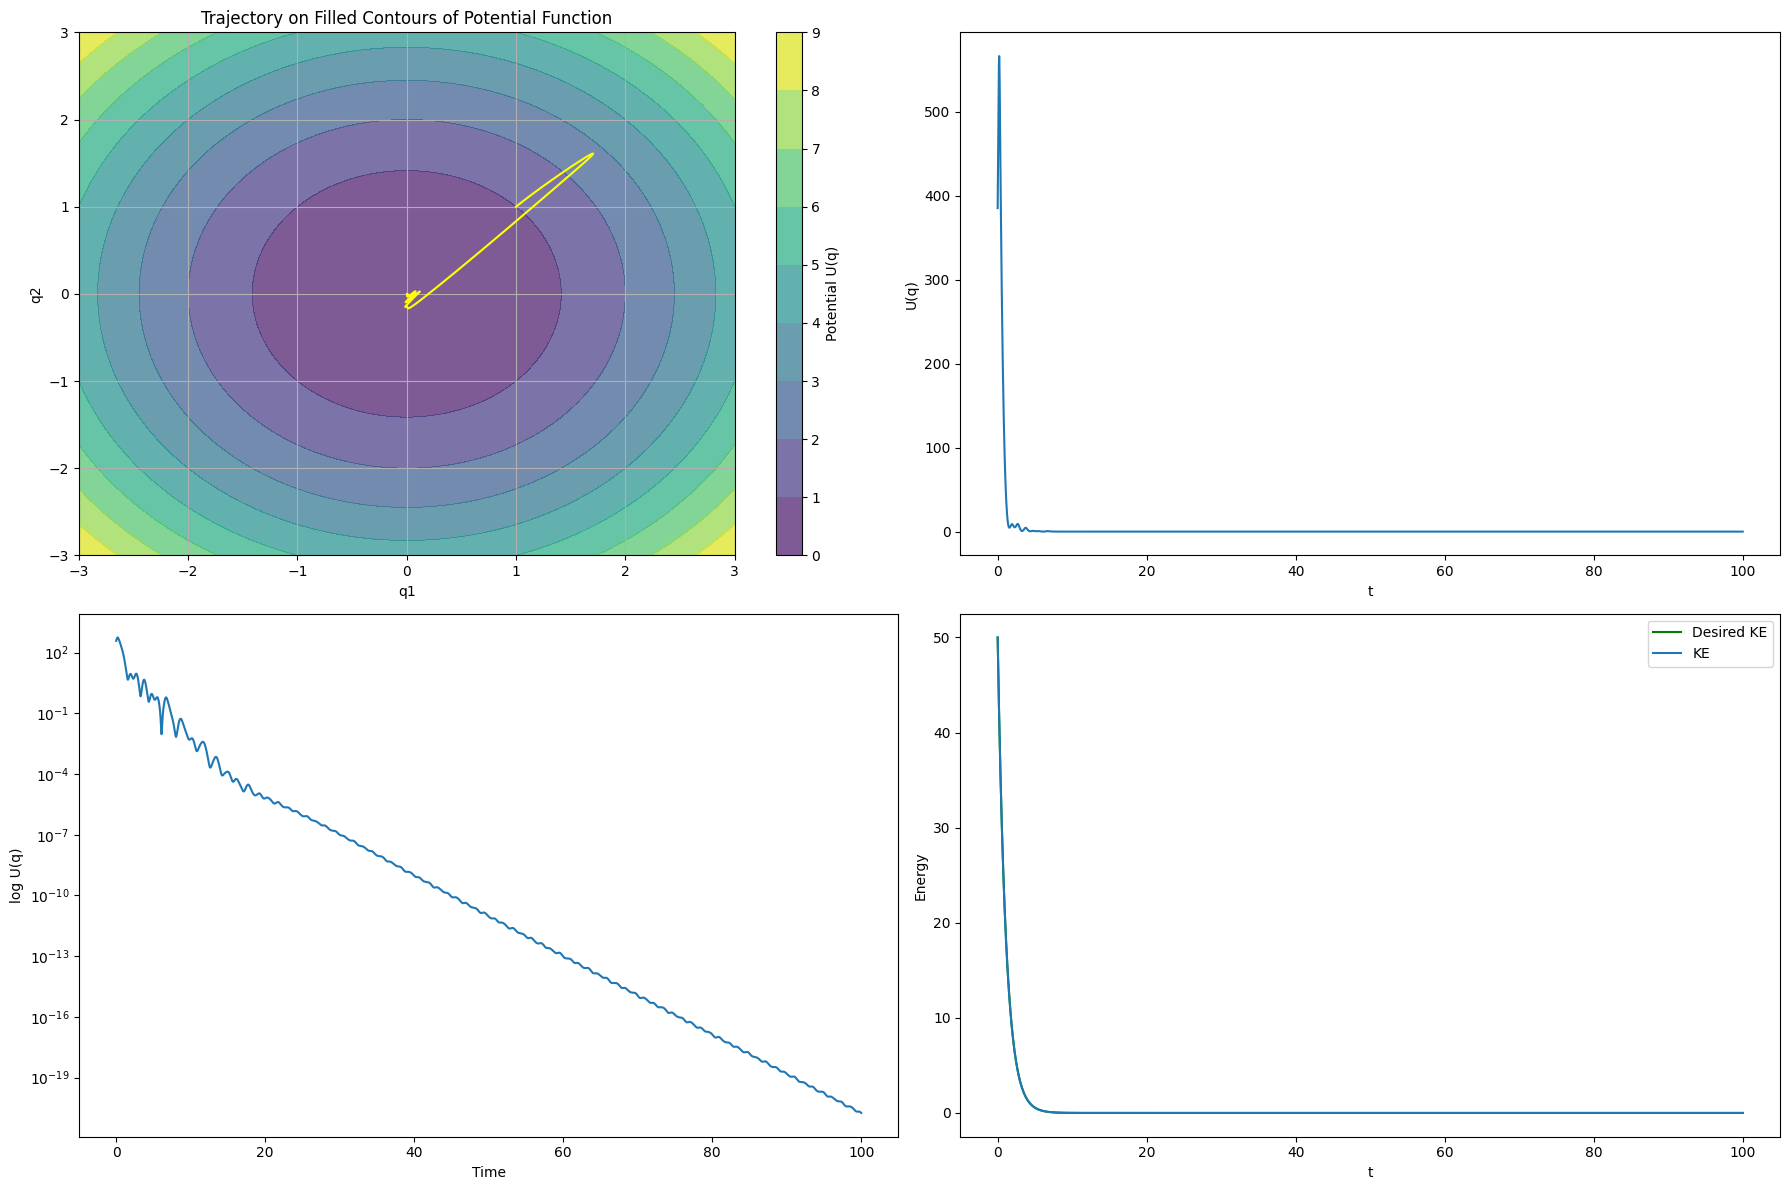

In [313]:
rho = 0.9
d = 50
A = [np.power(rho, np.abs(i-j)) 
            for i in range(1,d+1) for j in range(1,d+1)]
A = np.array(A)
A = A.reshape((d,d))


pars = {
    'c0': 50.,
    'gamma': 0.9
}
Ns = 10000
h = 0.01
q0 = np.ones(d) #np.random.normal(0, 10, d)
p0 = np.ones(d) * np.sqrt(2)
Q = [q0]
P = [p0]
T = [0]
q = q0
p = p0
t = 0
U_corr = lambda x: 0.5 * np.inner(x,np.inner(A,x))
Force_corr = lambda x: -A.dot(x)
U = [U_corr(q)]
for n in range(Ns):
    q, p = kd_step(q, p, h, pars, Force_corr)
    t += h
    Q.append(q)
    P.append(p)
    U.append(U_corr(q))
    T.append(t)
Q = np.array(Q)
P = np.array(P)
U = np.array(U)
T = np.array(T)

potential_lambda = lambda X,Y: 0.5 * (X**2 + Y**2)
plot_diagnostics_2D(Q,P,T,U,potential_lambda,pars['c0'],pars['gamma'],lim=3)

# Questions
 
In the approach to the minimum

i. do we lose any generalisability

ii. do we see similar convergence rate locally to plain momentum stochastic gradient descent

iii. do we see improved stability at large stepsize compared to popular schemes for momentum SGD - At the moment, it does not even converge for larger stepsizes, probably due to the RK4 error.

iv. is it affine invariant?

v. What is the integrator error?

vi. What is the convergence rate precisely?

vii. How does gamma, p0, and c0 impact convergence rate and error?
